# Dog Heart Vertebral Heart Size Point Detection
# 1. Build an object detection model using pytorch

In [5]:
!pip install torchmetrics
!pip install efficientnet-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 31.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=af637794d959bfc01c4f8aea92f92bbc72362beccfecd08e0199c26e96830042
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import torch
from scipy.io import loadmat
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from torchmetrics.classification import MulticlassAccuracy
from torchvision.models import resnet50
from efficientnet_pytorch import EfficientNet
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
import gc
filterwarnings('ignore')

In [7]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True
torch.cuda.empty_cache()

In [8]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Update the DogHeartDataset class to use Google Drive paths
class DogHeartDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # Define paths to Google Drive folders
        images_path = os.path.join('/content/drive/MyDrive', root, "Images")
        labels_path = os.path.join('/content/drive/MyDrive', root, "Labels")
        # Load all image and label files
        self.imgs = list(sorted(os.listdir(images_path)))
        self.points = list(sorted(os.listdir(labels_path)))

    def __getitem__(self, idx):
        # Load images and labels
        img_path = os.path.join('/content/drive/MyDrive', self.root, "Images", self.imgs[idx])
        points_path = os.path.join('/content/drive/MyDrive', self.root, "Labels", self.points[idx])
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        if self.transforms is not None:
            img = self.transforms(img)
        h_new, w_new = img.shape[1], img.shape[2]
        mat = loadmat(points_path)
        six_points = mat['six_points'].astype(float)
        six_points = torch.as_tensor(six_points, dtype=torch.float32)
        six_points[:, 0] = w_new / w * six_points[:, 0]  # Resize image to any size and maintain original points
        six_points[:, 1] = h_new / h * six_points[:, 1]
        six_points = torch.reshape(six_points, (-1,)) / h_new  # Normalize the points
        VHS = mat['VHS'].astype(float)
        VHS = torch.as_tensor(VHS, dtype=torch.float32)
        return img, six_points, VHS

    def __len__(self):
        return len(self.imgs)

def get_transform(resized_image_size):
    transforms = []
    transforms.append(T.ToTensor())
    transforms.append(T.Resize(size=(resized_image_size, resized_image_size)))
    transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    return T.Compose(transforms)

# For EfficientNetB7
batch_size = 4
resized_image_size = 512
learning_rate = 1e-4
num_epochs = 200

# Adjust dataset paths to point to Google Drive
dataset_train = DogHeartDataset('Train', get_transform(resized_image_size))
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataset_val = DogHeartDataset('Valid', get_transform(resized_image_size))
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False)


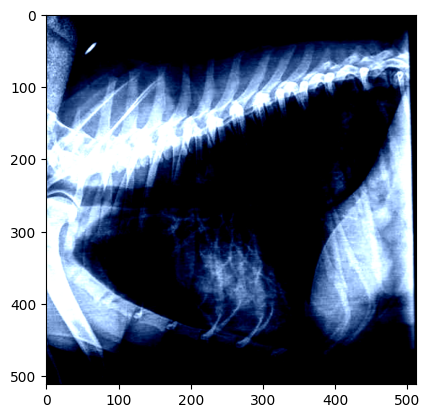

In [17]:
dataiter = iter(data_loader_train)
images, labels,_ = next(dataiter)
# Convert to (height, width, channels) for RGB images
plt.imshow(images[0].permute(1, 2, 0), cmap='gray')

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [19]:

class PointDetectionModel(nn.Module):
    def __init__(self, pretrained=True):
        super(PointDetectionModel, self).__init__()
        self.backbone = resnet50(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 12)  # 6 points (x, y)

    def forward(self, x):
        return self.backbone(x)

class EfficientNetV2XLPointDetectionModel(nn.Module):
    def __init__(self, pretrained=True):
        super(EfficientNetV2XLPointDetectionModel, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b7') if pretrained else EfficientNet.from_name('efficientnet-b7')
        self.fc = nn.Linear(self.efficientnet._fc.in_features, 12)  # 6 points with (x, y) coordinates
        self.efficientnet._fc = nn.Identity()

    def forward(self, x):
        features = self.efficientnet(x)
        outputs = self.fc(features)
        return outputs



In [20]:
def classify_vhs(vhs):
    if vhs < 8.2:
        return 0  # Small
    elif 8.2 <= vhs <= 10:
        return 1  # Normal
    else:
        return 2  # Large



def calculate_vhs(points):
    if points.shape[0] != 12:
        print("Error: Incorrect number of points, expected 12 but got", points.shape[0])
    AB = torch.dist(points[0:2], points[2:4])
    CD = torch.dist(points[4:6], points[6:8])
    EF = torch.dist(points[8:10], points[10:12])
    VHS = 6 * (AB + CD) / EF
    return round(VHS.item(), 6)



def calculate_metrics(vhs_true, vhs_pred):
    mse = mean_squared_error(vhs_true, vhs_pred)
    mae = mean_absolute_error(vhs_true, vhs_pred)
    true,pred = torch.tensor(vhs_true), torch.tensor(vhs_pred)
    mape = torch.mean(torch.abs((true - pred) / true)) * 100
    return mse, mae, mape


class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


# 2. Train your model using [Dog VHS Dataset](https://yuad-my.sharepoint.com/:f:/g/personal/youshan_zhang_yu_edu/ErguFJBE4y9KqzEdWWNlXzMBkTbsBaNX9l856SyvQauwJg?e=L3JOuN)

In [21]:
# model = PointDetectionModel(pretrained=True).to(device)
model = EfficientNetV2XLPointDetectionModel(pretrained=True).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
early_stopping = EarlyStopping(patience=5, verbose=True)
accuracy_metric = MulticlassAccuracy(num_classes=3)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:02<00:00, 113MB/s]


Loaded pretrained weights for efficientnet-b7


In [22]:
train_losses = []
val_losses = []
train_vhs_true, train_vhs_pred = [], []
val_vhs_true, val_vhs_pred = [],[]
train_vhs_true_class, train_vhs_pred_class = [], []
val_vhs_true_class, val_vhs_pred_class = [],[]

torch.cuda.manual_seed(8)

for epoch in range(num_epochs):
    model.train()
    train_vhs_pred, train_vhs_true = [], []  # Reset for each epoch
    train_vhs_true_class, train_vhs_pred_class = [], []
    running_train_loss = 0.0
    for imgs, six_points, vhs in tqdm(data_loader_train, unit="batch"):
        imgs, six_points = imgs.to(device), six_points.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, six_points)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        imgs,six_points = imgs.cpu(),six_points.cpu()

        for i in range(len(vhs)):
            vhs_pred = calculate_vhs(outputs[i].view(-1).cpu())
            train_vhs_true.append(vhs[i].cpu().item())
            train_vhs_pred.append(vhs_pred)
            train_vhs_true_class.append(classify_vhs(vhs[i].cpu().item()))  # Classify VHS
            train_vhs_pred_class.append(classify_vhs(vhs_pred))

    avg_train_loss = running_train_loss / len(data_loader_train) *100
    train_losses.append(avg_train_loss)

    train_accuracy = accuracy_metric(torch.tensor(train_vhs_pred_class), torch.tensor(train_vhs_true_class))

    model.eval()
    running_val_loss = 0.0
    val_vhs_true, val_vhs_pred = [], []  # Reset for each epoch
    val_vhs_true_class, val_vhs_pred_class = [], []
    with torch.no_grad():
        for imgs, six_points, vhs in tqdm(data_loader_val, unit="batch"):
            imgs, six_points = imgs.to(device), six_points.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, six_points)
            running_val_loss += loss.item()
            imgs,six_points = imgs.cpu(),six_points.cpu()

            for i in range(len(vhs)):
                vhs_pred = calculate_vhs(outputs[i].view(-1).cpu())
                val_vhs_true.append(vhs[i].cpu().item())
                val_vhs_pred.append(vhs_pred)
                val_vhs_true_class.append(classify_vhs(vhs[i].cpu().item()))  # Classify VHS
                val_vhs_pred_class.append(classify_vhs(vhs_pred))

    avg_val_loss = running_val_loss / len(data_loader_val) *100
    val_losses.append(avg_val_loss)

    val_accuracy = accuracy_metric(torch.tensor(val_vhs_pred_class), torch.tensor(val_vhs_true_class))

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy.item():.2%}, Validation Accuracy: {val_accuracy.item():.2%}")

    scheduler.step(avg_val_loss)
    # early_stopping(avg_val_loss,val_accuracy , model)
    # early_stopping(avg_val_loss, model)

    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break

    # Clear GPU cache
    torch.cuda.empty_cache()
    gc.collect()



100%|██████████| 200/200 [02:19<00:00,  1.43batch/s]


Epoch [1/200], Training Loss: 2.8099, Validation Loss: 1.3933
Training Accuracy: 38.04%, Validation Accuracy: 34.65%


100%|██████████| 200/200 [00:18<00:00, 10.66batch/s]


Epoch [2/200], Training Loss: 0.6708, Validation Loss: 0.3726
Training Accuracy: 36.90%, Validation Accuracy: 33.33%


100%|██████████| 200/200 [00:19<00:00, 10.32batch/s]


Epoch [3/200], Training Loss: 0.4297, Validation Loss: 0.1358
Training Accuracy: 40.06%, Validation Accuracy: 37.57%


100%|██████████| 200/200 [00:19<00:00, 10.23batch/s]


Epoch [4/200], Training Loss: 0.3270, Validation Loss: 0.1648
Training Accuracy: 40.99%, Validation Accuracy: 38.23%


100%|██████████| 200/200 [00:19<00:00, 10.39batch/s]


Epoch [5/200], Training Loss: 0.2703, Validation Loss: 0.1349
Training Accuracy: 43.53%, Validation Accuracy: 48.52%


100%|██████████| 200/200 [00:19<00:00, 10.44batch/s]


Epoch [6/200], Training Loss: 0.2441, Validation Loss: 0.2275
Training Accuracy: 42.48%, Validation Accuracy: 46.85%


100%|██████████| 200/200 [00:18<00:00, 10.72batch/s]


Epoch [7/200], Training Loss: 0.2067, Validation Loss: 0.0705
Training Accuracy: 42.86%, Validation Accuracy: 46.49%


100%|██████████| 200/200 [00:18<00:00, 10.74batch/s]


Epoch [8/200], Training Loss: 0.1967, Validation Loss: 0.0768
Training Accuracy: 45.80%, Validation Accuracy: 37.00%


100%|██████████| 200/200 [00:18<00:00, 10.66batch/s]


Epoch [9/200], Training Loss: 0.1715, Validation Loss: 0.0679
Training Accuracy: 44.11%, Validation Accuracy: 44.45%


100%|██████████| 200/200 [00:18<00:00, 10.63batch/s]


Epoch [10/200], Training Loss: 0.1716, Validation Loss: 0.0783
Training Accuracy: 46.02%, Validation Accuracy: 42.32%


100%|██████████| 200/200 [00:19<00:00, 10.06batch/s]


Epoch [11/200], Training Loss: 0.1562, Validation Loss: 0.0581
Training Accuracy: 45.05%, Validation Accuracy: 36.26%


100%|██████████| 200/200 [00:18<00:00, 10.53batch/s]


Epoch [12/200], Training Loss: 0.1394, Validation Loss: 0.0846
Training Accuracy: 44.13%, Validation Accuracy: 38.28%


100%|██████████| 200/200 [00:19<00:00, 10.38batch/s]


Epoch [13/200], Training Loss: 0.1234, Validation Loss: 0.0440
Training Accuracy: 45.86%, Validation Accuracy: 67.31%


100%|██████████| 200/200 [00:19<00:00, 10.43batch/s]


Epoch [14/200], Training Loss: 0.1161, Validation Loss: 0.0587
Training Accuracy: 47.11%, Validation Accuracy: 43.37%


100%|██████████| 200/200 [00:19<00:00, 10.34batch/s]


Epoch [15/200], Training Loss: 0.1256, Validation Loss: 0.0406
Training Accuracy: 44.58%, Validation Accuracy: 49.94%


100%|██████████| 200/200 [00:18<00:00, 10.70batch/s]


Epoch [16/200], Training Loss: 0.1073, Validation Loss: 0.0422
Training Accuracy: 47.84%, Validation Accuracy: 40.23%


100%|██████████| 200/200 [00:18<00:00, 10.58batch/s]


Epoch [17/200], Training Loss: 0.1078, Validation Loss: 0.0699
Training Accuracy: 45.47%, Validation Accuracy: 49.06%


100%|██████████| 200/200 [00:18<00:00, 10.78batch/s]


Epoch [18/200], Training Loss: 0.1057, Validation Loss: 0.0460
Training Accuracy: 46.83%, Validation Accuracy: 52.36%


100%|██████████| 200/200 [00:18<00:00, 10.67batch/s]


Epoch [19/200], Training Loss: 0.0977, Validation Loss: 0.0748
Training Accuracy: 47.73%, Validation Accuracy: 36.82%


100%|██████████| 200/200 [00:18<00:00, 10.79batch/s]


Epoch [20/200], Training Loss: 0.0938, Validation Loss: 0.0438
Training Accuracy: 48.40%, Validation Accuracy: 46.47%


100%|██████████| 200/200 [00:19<00:00, 10.39batch/s]


Epoch [21/200], Training Loss: 0.0907, Validation Loss: 0.0406
Training Accuracy: 45.96%, Validation Accuracy: 44.17%


100%|██████████| 200/200 [00:18<00:00, 10.72batch/s]


Epoch [22/200], Training Loss: 0.0736, Validation Loss: 0.0269
Training Accuracy: 46.92%, Validation Accuracy: 46.71%


100%|██████████| 200/200 [00:18<00:00, 10.70batch/s]


Epoch [23/200], Training Loss: 0.0724, Validation Loss: 0.0449
Training Accuracy: 47.49%, Validation Accuracy: 43.59%


100%|██████████| 200/200 [00:18<00:00, 10.96batch/s]


Epoch [24/200], Training Loss: 0.0657, Validation Loss: 0.0281
Training Accuracy: 45.34%, Validation Accuracy: 63.12%


100%|██████████| 200/200 [00:18<00:00, 10.83batch/s]


Epoch [25/200], Training Loss: 0.0641, Validation Loss: 0.0304
Training Accuracy: 48.51%, Validation Accuracy: 46.85%


100%|██████████| 200/200 [00:19<00:00, 10.30batch/s]


Epoch [26/200], Training Loss: 0.0638, Validation Loss: 0.0343
Training Accuracy: 48.04%, Validation Accuracy: 46.30%


100%|██████████| 200/200 [00:18<00:00, 10.61batch/s]


Epoch [27/200], Training Loss: 0.0622, Validation Loss: 0.0234
Training Accuracy: 47.60%, Validation Accuracy: 44.17%


100%|██████████| 200/200 [00:18<00:00, 10.58batch/s]


Epoch [28/200], Training Loss: 0.0615, Validation Loss: 0.0399
Training Accuracy: 47.51%, Validation Accuracy: 43.81%


100%|██████████| 200/200 [00:18<00:00, 10.87batch/s]


Epoch [29/200], Training Loss: 0.0605, Validation Loss: 0.0242
Training Accuracy: 46.81%, Validation Accuracy: 59.54%


100%|██████████| 200/200 [00:18<00:00, 10.74batch/s]


Epoch [30/200], Training Loss: 0.0584, Validation Loss: 0.0302
Training Accuracy: 48.75%, Validation Accuracy: 52.35%


100%|██████████| 200/200 [00:18<00:00, 10.84batch/s]


Epoch [31/200], Training Loss: 0.0603, Validation Loss: 0.0294
Training Accuracy: 49.13%, Validation Accuracy: 45.99%


100%|██████████| 200/200 [00:19<00:00, 10.33batch/s]


Epoch [32/200], Training Loss: 0.0584, Validation Loss: 0.0251
Training Accuracy: 48.27%, Validation Accuracy: 44.19%


100%|██████████| 200/200 [00:19<00:00, 10.13batch/s]


Epoch [33/200], Training Loss: 0.0559, Validation Loss: 0.0496
Training Accuracy: 48.21%, Validation Accuracy: 46.01%


100%|██████████| 200/200 [00:18<00:00, 10.86batch/s]


Epoch [34/200], Training Loss: 0.0488, Validation Loss: 0.0243
Training Accuracy: 46.92%, Validation Accuracy: 48.89%


100%|██████████| 200/200 [00:18<00:00, 10.89batch/s]


Epoch [35/200], Training Loss: 0.0439, Validation Loss: 0.0226
Training Accuracy: 49.58%, Validation Accuracy: 50.63%


100%|██████████| 200/200 [00:18<00:00, 10.58batch/s]


Epoch [36/200], Training Loss: 0.0461, Validation Loss: 0.0267
Training Accuracy: 49.26%, Validation Accuracy: 52.51%


100%|██████████| 200/200 [00:19<00:00, 10.22batch/s]


Epoch [37/200], Training Loss: 0.0454, Validation Loss: 0.0329
Training Accuracy: 49.21%, Validation Accuracy: 45.62%


100%|██████████| 200/200 [00:18<00:00, 10.68batch/s]


Epoch [38/200], Training Loss: 0.0433, Validation Loss: 0.0245
Training Accuracy: 49.42%, Validation Accuracy: 49.61%


100%|██████████| 200/200 [00:18<00:00, 10.76batch/s]


Epoch [39/200], Training Loss: 0.0421, Validation Loss: 0.0246
Training Accuracy: 49.46%, Validation Accuracy: 41.49%


100%|██████████| 200/200 [00:18<00:00, 10.76batch/s]


Epoch [40/200], Training Loss: 0.0436, Validation Loss: 0.0365
Training Accuracy: 48.71%, Validation Accuracy: 47.01%


100%|██████████| 200/200 [00:18<00:00, 10.71batch/s]


Epoch [41/200], Training Loss: 0.0413, Validation Loss: 0.0420
Training Accuracy: 48.84%, Validation Accuracy: 50.56%


100%|██████████| 200/200 [00:18<00:00, 10.71batch/s]


Epoch [42/200], Training Loss: 0.0391, Validation Loss: 0.0211
Training Accuracy: 48.34%, Validation Accuracy: 47.00%


100%|██████████| 200/200 [00:18<00:00, 10.83batch/s]


Epoch [43/200], Training Loss: 0.0369, Validation Loss: 0.0207
Training Accuracy: 48.75%, Validation Accuracy: 48.32%


100%|██████████| 200/200 [00:19<00:00, 10.49batch/s]


Epoch [44/200], Training Loss: 0.0359, Validation Loss: 0.0241
Training Accuracy: 50.32%, Validation Accuracy: 45.25%


100%|██████████| 200/200 [00:19<00:00, 10.45batch/s]


Epoch [45/200], Training Loss: 0.0358, Validation Loss: 0.0210
Training Accuracy: 48.79%, Validation Accuracy: 51.35%


100%|██████████| 200/200 [00:19<00:00, 10.50batch/s]


Epoch [46/200], Training Loss: 0.0355, Validation Loss: 0.0256
Training Accuracy: 49.63%, Validation Accuracy: 47.18%


100%|██████████| 200/200 [00:18<00:00, 10.76batch/s]


Epoch [47/200], Training Loss: 0.0362, Validation Loss: 0.0208
Training Accuracy: 49.80%, Validation Accuracy: 47.82%


100%|██████████| 200/200 [00:18<00:00, 10.76batch/s]


Epoch [48/200], Training Loss: 0.0333, Validation Loss: 0.0208
Training Accuracy: 49.11%, Validation Accuracy: 50.03%


100%|██████████| 200/200 [00:19<00:00, 10.47batch/s]


Epoch [49/200], Training Loss: 0.0339, Validation Loss: 0.0213
Training Accuracy: 51.01%, Validation Accuracy: 50.91%


100%|██████████| 200/200 [00:19<00:00, 10.18batch/s]


Epoch [50/200], Training Loss: 0.0339, Validation Loss: 0.0191
Training Accuracy: 49.79%, Validation Accuracy: 52.58%


100%|██████████| 200/200 [00:18<00:00, 10.86batch/s]


Epoch [51/200], Training Loss: 0.0330, Validation Loss: 0.0186
Training Accuracy: 48.02%, Validation Accuracy: 51.20%


100%|██████████| 200/200 [00:18<00:00, 10.84batch/s]


Epoch [52/200], Training Loss: 0.0329, Validation Loss: 0.0199
Training Accuracy: 49.04%, Validation Accuracy: 48.39%


100%|██████████| 200/200 [00:19<00:00, 10.47batch/s]


Epoch [53/200], Training Loss: 0.0327, Validation Loss: 0.0195
Training Accuracy: 48.86%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:18<00:00, 10.63batch/s]


Epoch [54/200], Training Loss: 0.0327, Validation Loss: 0.0192
Training Accuracy: 49.74%, Validation Accuracy: 51.49%


100%|██████████| 200/200 [00:18<00:00, 10.81batch/s]


Epoch [55/200], Training Loss: 0.0324, Validation Loss: 0.0195
Training Accuracy: 50.40%, Validation Accuracy: 52.87%


100%|██████████| 200/200 [00:18<00:00, 10.90batch/s]


Epoch [56/200], Training Loss: 0.0315, Validation Loss: 0.0214
Training Accuracy: 49.02%, Validation Accuracy: 51.48%


100%|██████████| 200/200 [00:18<00:00, 10.89batch/s]


Epoch [57/200], Training Loss: 0.0328, Validation Loss: 0.0193
Training Accuracy: 49.50%, Validation Accuracy: 52.43%


100%|██████████| 200/200 [00:18<00:00, 10.90batch/s]


Epoch [58/200], Training Loss: 0.0311, Validation Loss: 0.0193
Training Accuracy: 49.74%, Validation Accuracy: 51.99%


100%|██████████| 200/200 [00:18<00:00, 10.84batch/s]


Epoch [59/200], Training Loss: 0.0312, Validation Loss: 0.0195
Training Accuracy: 49.97%, Validation Accuracy: 50.41%


100%|██████████| 200/200 [00:19<00:00, 10.05batch/s]


Epoch [60/200], Training Loss: 0.0304, Validation Loss: 0.0193
Training Accuracy: 50.04%, Validation Accuracy: 50.41%


100%|██████████| 200/200 [00:19<00:00, 10.45batch/s]


Epoch [61/200], Training Loss: 0.0307, Validation Loss: 0.0200
Training Accuracy: 50.22%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:18<00:00, 10.58batch/s]


Epoch [62/200], Training Loss: 0.0287, Validation Loss: 0.0198
Training Accuracy: 48.96%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.74batch/s]


Epoch [63/200], Training Loss: 0.0305, Validation Loss: 0.0199
Training Accuracy: 50.89%, Validation Accuracy: 48.96%


100%|██████████| 200/200 [00:18<00:00, 10.89batch/s]


Epoch [64/200], Training Loss: 0.0299, Validation Loss: 0.0191
Training Accuracy: 51.02%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.62batch/s]


Epoch [65/200], Training Loss: 0.0287, Validation Loss: 0.0190
Training Accuracy: 49.78%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.36batch/s]


Epoch [66/200], Training Loss: 0.0297, Validation Loss: 0.0191
Training Accuracy: 50.90%, Validation Accuracy: 51.99%


100%|██████████| 200/200 [00:18<00:00, 10.72batch/s]


Epoch [67/200], Training Loss: 0.0293, Validation Loss: 0.0189
Training Accuracy: 51.02%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.78batch/s]


Epoch [68/200], Training Loss: 0.0290, Validation Loss: 0.0198
Training Accuracy: 49.83%, Validation Accuracy: 51.99%


100%|██████████| 200/200 [00:18<00:00, 10.66batch/s]


Epoch [69/200], Training Loss: 0.0291, Validation Loss: 0.0196
Training Accuracy: 49.88%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.54batch/s]


Epoch [70/200], Training Loss: 0.0279, Validation Loss: 0.0188
Training Accuracy: 49.66%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.54batch/s]


Epoch [71/200], Training Loss: 0.0292, Validation Loss: 0.0192
Training Accuracy: 50.33%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:19<00:00, 10.50batch/s]


Epoch [72/200], Training Loss: 0.0292, Validation Loss: 0.0188
Training Accuracy: 51.02%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.72batch/s]


Epoch [73/200], Training Loss: 0.0282, Validation Loss: 0.0190
Training Accuracy: 48.86%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:18<00:00, 10.68batch/s]


Epoch [74/200], Training Loss: 0.0294, Validation Loss: 0.0191
Training Accuracy: 50.80%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.57batch/s]


Epoch [75/200], Training Loss: 0.0287, Validation Loss: 0.0191
Training Accuracy: 50.05%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.83batch/s]


Epoch [76/200], Training Loss: 0.0304, Validation Loss: 0.0191
Training Accuracy: 49.52%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:18<00:00, 10.57batch/s]


Epoch [77/200], Training Loss: 0.0293, Validation Loss: 0.0196
Training Accuracy: 49.83%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:19<00:00, 10.24batch/s]


Epoch [78/200], Training Loss: 0.0290, Validation Loss: 0.0192
Training Accuracy: 50.54%, Validation Accuracy: 51.99%


100%|██████████| 200/200 [00:20<00:00,  9.93batch/s]


Epoch [79/200], Training Loss: 0.0281, Validation Loss: 0.0193
Training Accuracy: 50.97%, Validation Accuracy: 51.99%


100%|██████████| 200/200 [00:18<00:00, 10.66batch/s]


Epoch [80/200], Training Loss: 0.0283, Validation Loss: 0.0191
Training Accuracy: 50.35%, Validation Accuracy: 51.99%


100%|██████████| 200/200 [00:18<00:00, 10.71batch/s]


Epoch [81/200], Training Loss: 0.0282, Validation Loss: 0.0193
Training Accuracy: 50.35%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.17batch/s]


Epoch [82/200], Training Loss: 0.0294, Validation Loss: 0.0190
Training Accuracy: 50.10%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:19<00:00, 10.29batch/s]


Epoch [83/200], Training Loss: 0.0284, Validation Loss: 0.0191
Training Accuracy: 51.68%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:19<00:00, 10.31batch/s]


Epoch [84/200], Training Loss: 0.0277, Validation Loss: 0.0190
Training Accuracy: 49.81%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.57batch/s]


Epoch [85/200], Training Loss: 0.0277, Validation Loss: 0.0193
Training Accuracy: 49.36%, Validation Accuracy: 51.99%


100%|██████████| 200/200 [00:19<00:00, 10.51batch/s]


Epoch [86/200], Training Loss: 0.0294, Validation Loss: 0.0191
Training Accuracy: 49.33%, Validation Accuracy: 50.54%


100%|██████████| 200/200 [00:18<00:00, 10.69batch/s]


Epoch [87/200], Training Loss: 0.0299, Validation Loss: 0.0191
Training Accuracy: 51.04%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:18<00:00, 10.70batch/s]


Epoch [88/200], Training Loss: 0.0282, Validation Loss: 0.0190
Training Accuracy: 49.48%, Validation Accuracy: 50.54%


100%|██████████| 200/200 [00:18<00:00, 10.84batch/s]


Epoch [89/200], Training Loss: 0.0282, Validation Loss: 0.0192
Training Accuracy: 50.71%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:19<00:00, 10.23batch/s]


Epoch [90/200], Training Loss: 0.0280, Validation Loss: 0.0193
Training Accuracy: 50.10%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:19<00:00, 10.52batch/s]


Epoch [91/200], Training Loss: 0.0287, Validation Loss: 0.0190
Training Accuracy: 48.56%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:19<00:00, 10.44batch/s]


Epoch [92/200], Training Loss: 0.0278, Validation Loss: 0.0194
Training Accuracy: 50.00%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.61batch/s]


Epoch [93/200], Training Loss: 0.0295, Validation Loss: 0.0193
Training Accuracy: 51.48%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:19<00:00, 10.08batch/s]


Epoch [94/200], Training Loss: 0.0295, Validation Loss: 0.0190
Training Accuracy: 49.56%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.80batch/s]


Epoch [95/200], Training Loss: 0.0294, Validation Loss: 0.0190
Training Accuracy: 50.67%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:18<00:00, 10.55batch/s]


Epoch [96/200], Training Loss: 0.0289, Validation Loss: 0.0192
Training Accuracy: 49.31%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.28batch/s]


Epoch [97/200], Training Loss: 0.0295, Validation Loss: 0.0192
Training Accuracy: 50.53%, Validation Accuracy: 50.54%


100%|██████████| 200/200 [00:18<00:00, 10.63batch/s]


Epoch [98/200], Training Loss: 0.0295, Validation Loss: 0.0188
Training Accuracy: 50.42%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.66batch/s]


Epoch [99/200], Training Loss: 0.0302, Validation Loss: 0.0192
Training Accuracy: 49.69%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.42batch/s]


Epoch [100/200], Training Loss: 0.0301, Validation Loss: 0.0190
Training Accuracy: 48.47%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.74batch/s]


Epoch [101/200], Training Loss: 0.0292, Validation Loss: 0.0193
Training Accuracy: 50.24%, Validation Accuracy: 50.54%


100%|██████████| 200/200 [00:18<00:00, 10.72batch/s]


Epoch [102/200], Training Loss: 0.0301, Validation Loss: 0.0192
Training Accuracy: 49.26%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.63batch/s]


Epoch [103/200], Training Loss: 0.0290, Validation Loss: 0.0190
Training Accuracy: 50.84%, Validation Accuracy: 49.53%


100%|██████████| 200/200 [00:18<00:00, 10.58batch/s]


Epoch [104/200], Training Loss: 0.0291, Validation Loss: 0.0190
Training Accuracy: 48.68%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:19<00:00, 10.52batch/s]


Epoch [105/200], Training Loss: 0.0296, Validation Loss: 0.0191
Training Accuracy: 50.54%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:18<00:00, 10.59batch/s]


Epoch [106/200], Training Loss: 0.0294, Validation Loss: 0.0191
Training Accuracy: 50.08%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:18<00:00, 10.66batch/s]


Epoch [107/200], Training Loss: 0.0288, Validation Loss: 0.0190
Training Accuracy: 50.37%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.63batch/s]


Epoch [108/200], Training Loss: 0.0286, Validation Loss: 0.0193
Training Accuracy: 50.97%, Validation Accuracy: 49.53%


100%|██████████| 200/200 [00:19<00:00, 10.20batch/s]


Epoch [109/200], Training Loss: 0.0286, Validation Loss: 0.0194
Training Accuracy: 50.75%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.36batch/s]


Epoch [110/200], Training Loss: 0.0286, Validation Loss: 0.0195
Training Accuracy: 51.72%, Validation Accuracy: 50.54%


100%|██████████| 200/200 [00:19<00:00, 10.41batch/s]


Epoch [111/200], Training Loss: 0.0284, Validation Loss: 0.0195
Training Accuracy: 49.22%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:18<00:00, 10.65batch/s]


Epoch [112/200], Training Loss: 0.0287, Validation Loss: 0.0187
Training Accuracy: 49.09%, Validation Accuracy: 51.99%


100%|██████████| 200/200 [00:18<00:00, 10.61batch/s]


Epoch [113/200], Training Loss: 0.0302, Validation Loss: 0.0190
Training Accuracy: 50.11%, Validation Accuracy: 50.41%


100%|██████████| 200/200 [00:19<00:00, 10.48batch/s]


Epoch [114/200], Training Loss: 0.0285, Validation Loss: 0.0191
Training Accuracy: 50.65%, Validation Accuracy: 51.99%


100%|██████████| 200/200 [00:19<00:00, 10.33batch/s]


Epoch [115/200], Training Loss: 0.0293, Validation Loss: 0.0192
Training Accuracy: 49.98%, Validation Accuracy: 50.54%


100%|██████████| 200/200 [00:19<00:00, 10.51batch/s]


Epoch [116/200], Training Loss: 0.0289, Validation Loss: 0.0189
Training Accuracy: 49.63%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.70batch/s]


Epoch [117/200], Training Loss: 0.0286, Validation Loss: 0.0190
Training Accuracy: 49.85%, Validation Accuracy: 50.85%


100%|██████████| 200/200 [00:19<00:00, 10.49batch/s]


Epoch [118/200], Training Loss: 0.0288, Validation Loss: 0.0190
Training Accuracy: 50.18%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:19<00:00, 10.40batch/s]


Epoch [119/200], Training Loss: 0.0291, Validation Loss: 0.0190
Training Accuracy: 51.06%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:19<00:00, 10.46batch/s]


Epoch [120/200], Training Loss: 0.0284, Validation Loss: 0.0190
Training Accuracy: 51.18%, Validation Accuracy: 51.99%


100%|██████████| 200/200 [00:18<00:00, 10.64batch/s]


Epoch [121/200], Training Loss: 0.0294, Validation Loss: 0.0192
Training Accuracy: 50.21%, Validation Accuracy: 50.41%


100%|██████████| 200/200 [00:18<00:00, 10.70batch/s]


Epoch [122/200], Training Loss: 0.0282, Validation Loss: 0.0190
Training Accuracy: 50.52%, Validation Accuracy: 50.41%


100%|██████████| 200/200 [00:18<00:00, 10.57batch/s]


Epoch [123/200], Training Loss: 0.0287, Validation Loss: 0.0191
Training Accuracy: 48.35%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.31batch/s]


Epoch [124/200], Training Loss: 0.0290, Validation Loss: 0.0189
Training Accuracy: 50.75%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.35batch/s]


Epoch [125/200], Training Loss: 0.0288, Validation Loss: 0.0191
Training Accuracy: 50.45%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:19<00:00, 10.41batch/s]


Epoch [126/200], Training Loss: 0.0296, Validation Loss: 0.0193
Training Accuracy: 50.74%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:18<00:00, 10.64batch/s]


Epoch [127/200], Training Loss: 0.0295, Validation Loss: 0.0193
Training Accuracy: 51.85%, Validation Accuracy: 50.54%


100%|██████████| 200/200 [00:19<00:00, 10.14batch/s]


Epoch [128/200], Training Loss: 0.0287, Validation Loss: 0.0191
Training Accuracy: 49.57%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:19<00:00, 10.32batch/s]


Epoch [129/200], Training Loss: 0.0281, Validation Loss: 0.0192
Training Accuracy: 50.89%, Validation Accuracy: 51.99%


100%|██████████| 200/200 [00:18<00:00, 10.54batch/s]


Epoch [130/200], Training Loss: 0.0286, Validation Loss: 0.0190
Training Accuracy: 50.10%, Validation Accuracy: 51.99%


100%|██████████| 200/200 [00:19<00:00, 10.51batch/s]


Epoch [131/200], Training Loss: 0.0290, Validation Loss: 0.0191
Training Accuracy: 50.13%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.22batch/s]


Epoch [132/200], Training Loss: 0.0296, Validation Loss: 0.0193
Training Accuracy: 49.79%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:19<00:00, 10.20batch/s]


Epoch [133/200], Training Loss: 0.0288, Validation Loss: 0.0190
Training Accuracy: 50.66%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:19<00:00, 10.48batch/s]


Epoch [134/200], Training Loss: 0.0293, Validation Loss: 0.0195
Training Accuracy: 49.23%, Validation Accuracy: 50.54%


100%|██████████| 200/200 [00:20<00:00,  9.95batch/s]


Epoch [135/200], Training Loss: 0.0282, Validation Loss: 0.0190
Training Accuracy: 51.05%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:19<00:00, 10.35batch/s]


Epoch [136/200], Training Loss: 0.0283, Validation Loss: 0.0189
Training Accuracy: 50.20%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:19<00:00, 10.11batch/s]


Epoch [137/200], Training Loss: 0.0287, Validation Loss: 0.0192
Training Accuracy: 49.47%, Validation Accuracy: 50.41%


100%|██████████| 200/200 [00:19<00:00, 10.17batch/s]


Epoch [138/200], Training Loss: 0.0289, Validation Loss: 0.0189
Training Accuracy: 49.09%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:18<00:00, 10.65batch/s]


Epoch [139/200], Training Loss: 0.0289, Validation Loss: 0.0190
Training Accuracy: 50.01%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.56batch/s]


Epoch [140/200], Training Loss: 0.0295, Validation Loss: 0.0192
Training Accuracy: 49.47%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.17batch/s]


Epoch [141/200], Training Loss: 0.0293, Validation Loss: 0.0191
Training Accuracy: 51.22%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.12batch/s]


Epoch [142/200], Training Loss: 0.0306, Validation Loss: 0.0189
Training Accuracy: 51.90%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.57batch/s]


Epoch [143/200], Training Loss: 0.0280, Validation Loss: 0.0189
Training Accuracy: 51.05%, Validation Accuracy: 49.53%


100%|██████████| 200/200 [00:18<00:00, 10.65batch/s]


Epoch [144/200], Training Loss: 0.0296, Validation Loss: 0.0189
Training Accuracy: 49.98%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.42batch/s]


Epoch [145/200], Training Loss: 0.0288, Validation Loss: 0.0192
Training Accuracy: 51.44%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:20<00:00,  9.78batch/s]


Epoch [146/200], Training Loss: 0.0295, Validation Loss: 0.0192
Training Accuracy: 47.53%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.70batch/s]


Epoch [147/200], Training Loss: 0.0295, Validation Loss: 0.0191
Training Accuracy: 49.86%, Validation Accuracy: 51.99%


100%|██████████| 200/200 [00:18<00:00, 10.76batch/s]


Epoch [148/200], Training Loss: 0.0292, Validation Loss: 0.0195
Training Accuracy: 49.83%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:18<00:00, 10.62batch/s]


Epoch [149/200], Training Loss: 0.0276, Validation Loss: 0.0189
Training Accuracy: 49.86%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:18<00:00, 10.86batch/s]


Epoch [150/200], Training Loss: 0.0293, Validation Loss: 0.0192
Training Accuracy: 50.21%, Validation Accuracy: 50.54%


100%|██████████| 200/200 [00:18<00:00, 10.74batch/s]


Epoch [151/200], Training Loss: 0.0288, Validation Loss: 0.0190
Training Accuracy: 50.25%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.41batch/s]


Epoch [152/200], Training Loss: 0.0290, Validation Loss: 0.0193
Training Accuracy: 50.14%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:19<00:00, 10.47batch/s]


Epoch [153/200], Training Loss: 0.0300, Validation Loss: 0.0191
Training Accuracy: 50.37%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.60batch/s]


Epoch [154/200], Training Loss: 0.0281, Validation Loss: 0.0191
Training Accuracy: 48.72%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:19<00:00, 10.48batch/s]


Epoch [155/200], Training Loss: 0.0295, Validation Loss: 0.0192
Training Accuracy: 49.64%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:18<00:00, 10.79batch/s]


Epoch [156/200], Training Loss: 0.0300, Validation Loss: 0.0193
Training Accuracy: 50.65%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:18<00:00, 10.78batch/s]


Epoch [157/200], Training Loss: 0.0295, Validation Loss: 0.0192
Training Accuracy: 49.37%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.70batch/s]


Epoch [158/200], Training Loss: 0.0288, Validation Loss: 0.0190
Training Accuracy: 49.47%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.44batch/s]


Epoch [159/200], Training Loss: 0.0289, Validation Loss: 0.0189
Training Accuracy: 50.04%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:19<00:00, 10.43batch/s]


Epoch [160/200], Training Loss: 0.0285, Validation Loss: 0.0193
Training Accuracy: 50.49%, Validation Accuracy: 50.54%


100%|██████████| 200/200 [00:18<00:00, 10.68batch/s]


Epoch [161/200], Training Loss: 0.0300, Validation Loss: 0.0190
Training Accuracy: 48.94%, Validation Accuracy: 50.41%


100%|██████████| 200/200 [00:18<00:00, 10.59batch/s]


Epoch [162/200], Training Loss: 0.0292, Validation Loss: 0.0193
Training Accuracy: 50.99%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:19<00:00, 10.49batch/s]


Epoch [163/200], Training Loss: 0.0297, Validation Loss: 0.0191
Training Accuracy: 48.83%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.19batch/s]


Epoch [164/200], Training Loss: 0.0285, Validation Loss: 0.0190
Training Accuracy: 49.30%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:18<00:00, 10.70batch/s]


Epoch [165/200], Training Loss: 0.0286, Validation Loss: 0.0190
Training Accuracy: 51.06%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.28batch/s]


Epoch [166/200], Training Loss: 0.0303, Validation Loss: 0.0190
Training Accuracy: 50.85%, Validation Accuracy: 50.54%


100%|██████████| 200/200 [00:18<00:00, 10.61batch/s]


Epoch [167/200], Training Loss: 0.0291, Validation Loss: 0.0190
Training Accuracy: 49.76%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.66batch/s]


Epoch [168/200], Training Loss: 0.0300, Validation Loss: 0.0191
Training Accuracy: 50.14%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:18<00:00, 10.66batch/s]


Epoch [169/200], Training Loss: 0.0292, Validation Loss: 0.0192
Training Accuracy: 49.98%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.69batch/s]


Epoch [170/200], Training Loss: 0.0292, Validation Loss: 0.0191
Training Accuracy: 51.59%, Validation Accuracy: 50.41%


100%|██████████| 200/200 [00:19<00:00, 10.33batch/s]


Epoch [171/200], Training Loss: 0.0289, Validation Loss: 0.0190
Training Accuracy: 50.51%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.22batch/s]


Epoch [172/200], Training Loss: 0.0290, Validation Loss: 0.0189
Training Accuracy: 49.37%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.56batch/s]


Epoch [173/200], Training Loss: 0.0290, Validation Loss: 0.0192
Training Accuracy: 50.28%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.64batch/s]


Epoch [174/200], Training Loss: 0.0291, Validation Loss: 0.0191
Training Accuracy: 50.46%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.70batch/s]


Epoch [175/200], Training Loss: 0.0295, Validation Loss: 0.0190
Training Accuracy: 50.62%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.78batch/s]


Epoch [176/200], Training Loss: 0.0286, Validation Loss: 0.0193
Training Accuracy: 50.76%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.40batch/s]


Epoch [177/200], Training Loss: 0.0292, Validation Loss: 0.0191
Training Accuracy: 49.75%, Validation Accuracy: 50.41%


100%|██████████| 200/200 [00:19<00:00, 10.23batch/s]


Epoch [178/200], Training Loss: 0.0276, Validation Loss: 0.0190
Training Accuracy: 49.68%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:19<00:00, 10.46batch/s]


Epoch [179/200], Training Loss: 0.0297, Validation Loss: 0.0191
Training Accuracy: 49.96%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:18<00:00, 10.71batch/s]


Epoch [180/200], Training Loss: 0.0293, Validation Loss: 0.0193
Training Accuracy: 48.91%, Validation Accuracy: 50.54%


100%|██████████| 200/200 [00:18<00:00, 10.65batch/s]


Epoch [181/200], Training Loss: 0.0285, Validation Loss: 0.0192
Training Accuracy: 49.01%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.64batch/s]


Epoch [182/200], Training Loss: 0.0285, Validation Loss: 0.0189
Training Accuracy: 49.90%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:19<00:00, 10.40batch/s]


Epoch [183/200], Training Loss: 0.0289, Validation Loss: 0.0190
Training Accuracy: 48.61%, Validation Accuracy: 50.41%


100%|██████████| 200/200 [00:18<00:00, 10.63batch/s]


Epoch [184/200], Training Loss: 0.0273, Validation Loss: 0.0191
Training Accuracy: 50.07%, Validation Accuracy: 50.41%


100%|██████████| 200/200 [00:18<00:00, 10.58batch/s]


Epoch [185/200], Training Loss: 0.0294, Validation Loss: 0.0191
Training Accuracy: 50.37%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.65batch/s]


Epoch [186/200], Training Loss: 0.0288, Validation Loss: 0.0189
Training Accuracy: 49.94%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:19<00:00, 10.19batch/s]


Epoch [187/200], Training Loss: 0.0288, Validation Loss: 0.0191
Training Accuracy: 49.97%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.19batch/s]


Epoch [188/200], Training Loss: 0.0292, Validation Loss: 0.0192
Training Accuracy: 48.35%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:18<00:00, 10.59batch/s]


Epoch [189/200], Training Loss: 0.0295, Validation Loss: 0.0189
Training Accuracy: 50.42%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:19<00:00, 10.41batch/s]


Epoch [190/200], Training Loss: 0.0291, Validation Loss: 0.0193
Training Accuracy: 50.36%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:19<00:00, 10.17batch/s]


Epoch [191/200], Training Loss: 0.0289, Validation Loss: 0.0192
Training Accuracy: 50.25%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:18<00:00, 10.65batch/s]


Epoch [192/200], Training Loss: 0.0288, Validation Loss: 0.0192
Training Accuracy: 49.54%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:18<00:00, 10.55batch/s]


Epoch [193/200], Training Loss: 0.0289, Validation Loss: 0.0188
Training Accuracy: 49.74%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.14batch/s]


Epoch [194/200], Training Loss: 0.0290, Validation Loss: 0.0192
Training Accuracy: 49.23%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:19<00:00, 10.41batch/s]


Epoch [195/200], Training Loss: 0.0283, Validation Loss: 0.0189
Training Accuracy: 50.55%, Validation Accuracy: 51.55%


100%|██████████| 200/200 [00:18<00:00, 10.67batch/s]


Epoch [196/200], Training Loss: 0.0287, Validation Loss: 0.0190
Training Accuracy: 48.47%, Validation Accuracy: 51.99%


100%|██████████| 200/200 [00:18<00:00, 10.67batch/s]


Epoch [197/200], Training Loss: 0.0281, Validation Loss: 0.0190
Training Accuracy: 49.77%, Validation Accuracy: 49.97%


100%|██████████| 200/200 [00:19<00:00, 10.34batch/s]


Epoch [198/200], Training Loss: 0.0282, Validation Loss: 0.0190
Training Accuracy: 51.49%, Validation Accuracy: 51.99%


100%|██████████| 200/200 [00:18<00:00, 10.74batch/s]


Epoch [199/200], Training Loss: 0.0288, Validation Loss: 0.0193
Training Accuracy: 50.25%, Validation Accuracy: 50.98%


100%|██████████| 200/200 [00:18<00:00, 10.62batch/s]


Epoch [200/200], Training Loss: 0.0298, Validation Loss: 0.0192
Training Accuracy: 49.84%, Validation Accuracy: 49.97%


In [23]:
# Calculate and print metrics
train_vhs_true = torch.tensor(train_vhs_true).detach().numpy()
train_vhs_pred = torch.tensor(train_vhs_pred).detach().numpy()
val_vhs_true = torch.tensor(val_vhs_true).detach().numpy()
val_vhs_pred = torch.tensor(val_vhs_pred).detach().numpy()


train_mse, train_mae, train_mape = calculate_metrics(np.array(train_vhs_true), np.array(train_vhs_pred))
val_mse, val_mae, val_mape = calculate_metrics(np.array(val_vhs_true), np.array(val_vhs_pred))

print(f"Training MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, MAPE: {train_mape:.2f}%")
print(f"Validation MSE: {val_mse:.4f}, MAE: {val_mae:.4f}, MAPE: {val_mape:.2f}%")

Training MSE: 1.7739, MAE: 1.1264, MAPE: 11.89%
Validation MSE: 1.1965, MAE: 0.9244, MAPE: 10.07%


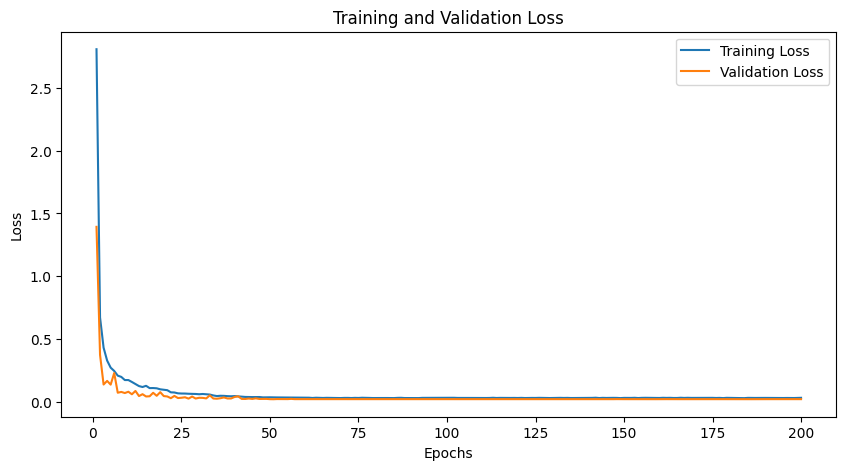

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

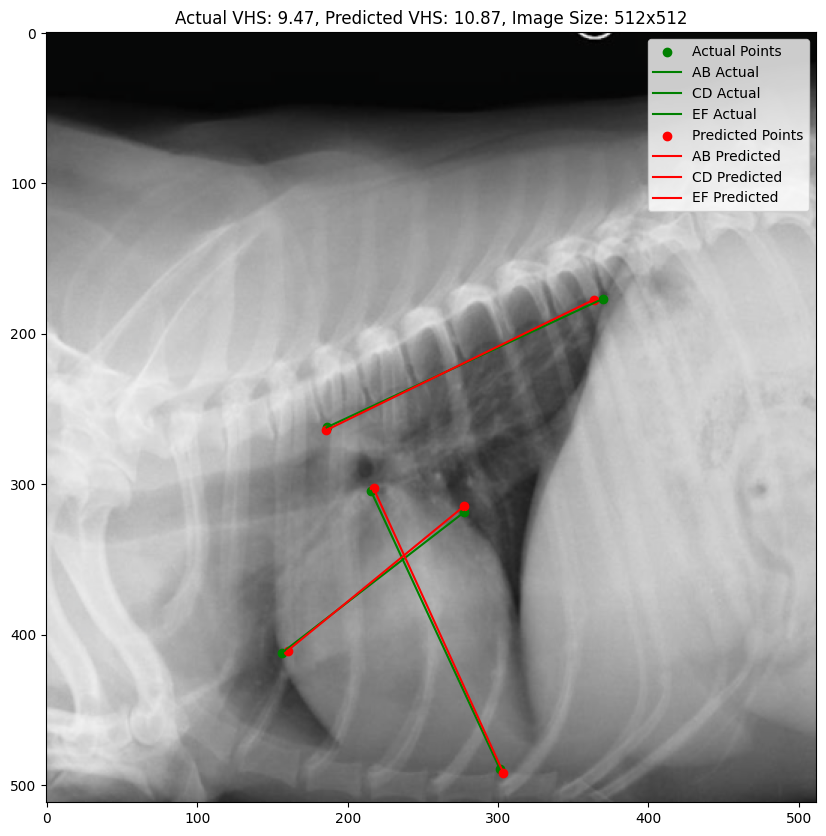

In [25]:
import random

def visualize_predictions(model, dataset, device, idx=None):
    model.eval()

    if idx is None:
        idx = random.randint(0, len(dataset) - 1)

    img, six_points_actual, vhs_actual = dataset[idx]
    img_resized = img.to(device).unsqueeze(0)
    six_points_actual = six_points_actual.view(-1, 2).cpu().numpy()
    vhs_actual = vhs_actual.item()

    with torch.no_grad():
        points_resized = model(img_resized).cpu().view(-1, 2).numpy()

    w, h = img.shape[2], img.shape[1]
    points_resized[:, 0] *= resized_image_size
    points_resized[:, 1] *= resized_image_size
    points_resized[:, 0] = w / resized_image_size * points_resized[:, 0]
    points_resized[:, 1] = h / resized_image_size * points_resized[:, 1]
    img = img.permute(1, 2, 0).cpu().numpy()
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
    img = np.clip(img, 0, 1)


    vhs_predicted = calculate_vhs(torch.tensor(points_resized).view(-1))

    plt.figure(figsize=(10, 10))
    plt.imshow(img)

    plt.scatter(six_points_actual[:, 0] * w, six_points_actual[:, 1] * h, c='g', label='Actual Points')
    plt.plot([six_points_actual[0, 0] * w, six_points_actual[1, 0] * w],
             [six_points_actual[0, 1] * h, six_points_actual[1, 1] * h], 'g-', label='AB Actual')
    plt.plot([six_points_actual[2, 0] * w, six_points_actual[3, 0] * w],
             [six_points_actual[2, 1] * h, six_points_actual[3, 1] * h], 'g-', label='CD Actual')
    plt.plot([six_points_actual[4, 0] * w, six_points_actual[5, 0] * w],
             [six_points_actual[4, 1] * h, six_points_actual[5, 1] * h], 'g-', label='EF Actual')

    plt.scatter(points_resized[:, 0], points_resized[:, 1], c='r', label='Predicted Points')
    plt.plot([points_resized[0, 0], points_resized[1, 0]],
             [points_resized[0, 1], points_resized[1, 1]], 'r-', label='AB Predicted')
    plt.plot([points_resized[2, 0], points_resized[3, 0]],
             [points_resized[2, 1], points_resized[3, 1]], 'r-', label='CD Predicted')
    plt.plot([points_resized[4, 0], points_resized[5, 0]],
             [points_resized[4, 1], points_resized[5, 1]], 'r-', label='EF Predicted')

    plt.title(f'Actual VHS: {vhs_actual:.2f}, Predicted VHS: {vhs_predicted:.2f}, Image Size: {w}x{h}')
    plt.legend()
    plt.show()

visualize_predictions(model, dataset_val, device)


In [37]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the test dataset in Google Drive
GDRIVE_TEST_DIR = '/content/drive/My Drive/Test'  # Adjust path to your Test folder in Google Drive

class DogHeartTestDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(root)))  # Directly load all images in the root directory

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.imgs[idx])  # Access images directly from the root
        img = Image.open(img_path).convert("RGB")
        original_size = img.size
        if self.transforms is not None:
            img = self.transforms(img)
        return img, img_path, original_size

    def __len__(self):
        return len(self.imgs)

def get_test_transform(resized_image_size):
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((resized_image_size, resized_image_size)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def test_predictions(model, dataset, device, resized_image_size=512, idx=None, save_csv=False, output_csv='test_predictions.csv'):
    model.eval()
    results = []
    vhs_score = 0

    if idx is None:
        idx = random.randint(0, len(dataset) - 1)

    for img, img_path, original_size in tqdm(dataset, desc="Processing images"):
        img_resized = img.to(device).unsqueeze(0)

        with torch.no_grad():
            outputs = model(img_resized).cpu().view(-1, 2).numpy()

        w, h = original_size

        # Scale points back to the original image size
        points_resized = outputs.reshape(-1, 2)
        points_resized[:, 0] = w * points_resized[:, 0]
        points_resized[:, 1] = h * points_resized[:, 1]

        # Calculate VHS score
        points_tensor = torch.tensor(points_resized).view(-1)
        vhs_score = round(calculate_vhs(points_tensor), 4)  # Remove `.item()`

        filename = os.path.basename(img_path)
        results.append([filename, vhs_score])

    if save_csv:
        df = pd.DataFrame(results, columns=['filename', 'vhs_score'])
        df.to_csv(output_csv, index=False)
        print(f"Results saved to {output_csv}")


# Initialize the test dataset from Google Drive directory
test_dataset = DogHeartTestDataset(GDRIVE_TEST_DIR, get_test_transform(resized_image_size=512))
test_predictions(model, test_dataset, device, resized_image_size=512, save_csv=True, output_csv='test_predictions.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Processing images: 100%|██████████| 400/400 [00:41<00:00,  9.65it/s]


Results saved to test_predictions.csv


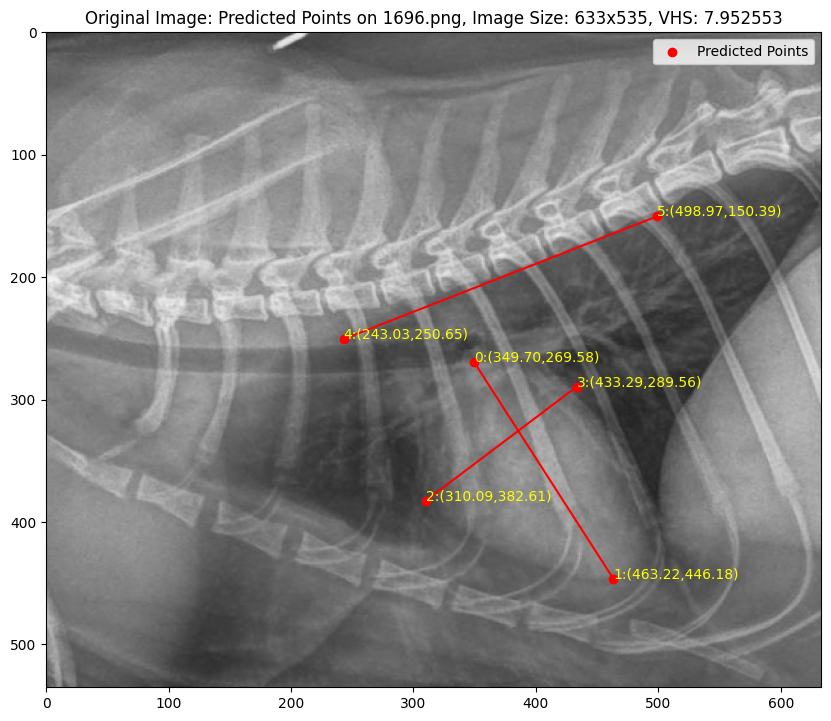

In [40]:
def calculate_vhs(points):
    if points.shape[0] != 12:
        print("Error: Incorrect number of points, expected 12 but got", points.shape[0])
    AB = torch.dist(points[0:2], points[2:4])
    CD = torch.dist(points[4:6], points[6:8])
    EF = torch.dist(points[8:10], points[10:12])
    VHS = 6 * (AB + CD) / EF
    return VHS

def visualize_test_predictions(model, dataset, device, resized_image_size=512, idx=None):
    model.eval()

    if idx is None:
        idx = random.randint(0, len(dataset) - 1)

    img, img_path, original_size = dataset[idx]
    img_resized = img.to(device).unsqueeze(0)

    with torch.no_grad():
        outputs = model(img_resized).cpu().view(-1, 2).numpy()

    w, h = original_size

    points_resized = outputs.reshape(-1, 2)
    points_resized[:, 0] = w * points_resized[:, 0]
    points_resized[:, 1] = h * points_resized[:, 1]

    # Calculate VHS score
    points_tensor = torch.tensor(points_resized).view(-1)
    vhs_score = calculate_vhs(points_tensor).item()

    # Unnormalize images
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img_np = np.clip(img_np, 0, 1)

    # Plot original image with predicted points
    plt.figure(figsize=(10, 10))
    plt.imshow(img_np, extent=[0, w, h, 0])
    plt.scatter(points_resized[:, 0], points_resized[:, 1], c='r', label='Predicted Points')
    for i, (x, y) in enumerate(points_resized):
        plt.text(x, y, f'{i}:({x:.2f},{y:.2f})', color='yellow')

    plt.plot([points_resized[0, 0], points_resized[1, 0]], [points_resized[0, 1], points_resized[1, 1]], 'r-')
    plt.plot([points_resized[2, 0], points_resized[3, 0]], [points_resized[2, 1], points_resized[3, 1]], 'r-')
    plt.plot([points_resized[4, 0], points_resized[5, 0]], [points_resized[4, 1], points_resized[5, 1]], 'r-')

    plt.title(f'Original Image: Predicted Points on {os.path.basename(img_path)}, Image Size: {w}x{h}, VHS: {vhs_score:.6f}')
    plt.legend()
    plt.show()


# Update: Point to the root of Google Colab
GDRIVE_IMAGE_PATH = '/content/1696.png'  # Image in the root of Colab

class DogHeartTestDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = [root]  # Directly use the single image path

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert("RGB")
        original_size = img.size
        if self.transforms is not None:
            img = self.transforms(img)
        return img, img_path, original_size

    def __len__(self):
        return len(self.imgs)


test_dataset = DogHeartTestDataset(GDRIVE_IMAGE_PATH, get_test_transform(resized_image_size=512))
visualize_test_predictions(model, test_dataset, device, resized_image_size=512)


# 3.Evaluate your model using the test images with the [software](https://github.com/YoushanZhang/Dog-Cardiomegaly_VHS)

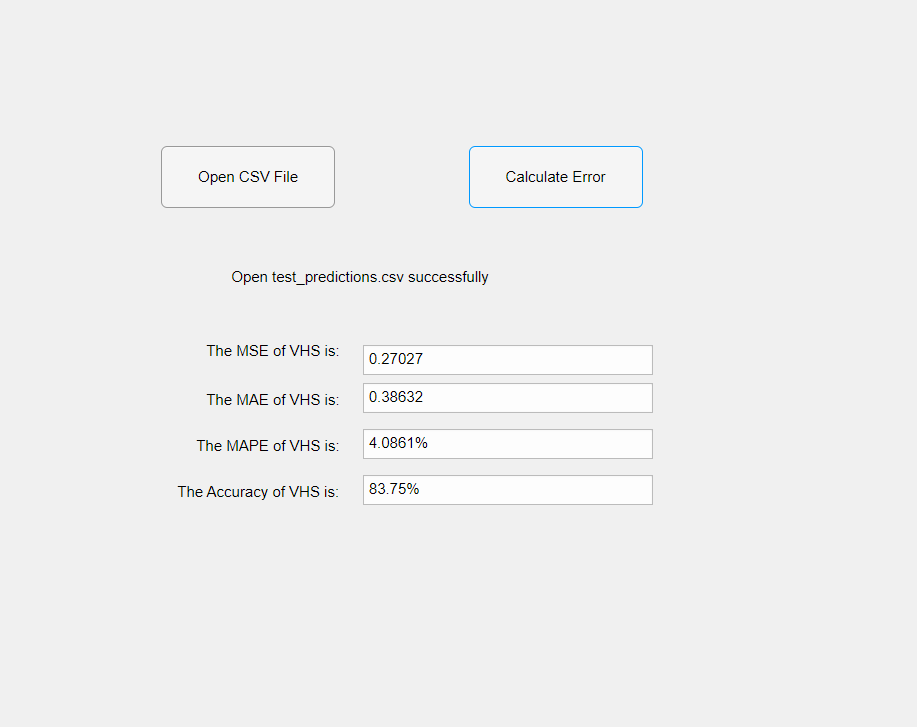

In [11]:
from IPython.display import Image, display

# Display the image
image_path = '/content/3.png'  # Path to the image in the root directory of Colab
display(Image(filename=image_path))

# 4. Your results should be achieved 85%. VHS = 6(AB+CD)/EF

## (10 points, accuracy < 75% --> 0 points)

### Results

The **Mean Squared Error (MSE)** of 0.27027 indicates a small average squared difference between the predicted and actual VHS values, demonstrating high precision in the model's predictions. The **Mean Absolute Error (MAE)** of 0.38632 supports this observation by revealing a low average magnitude of errors across the test dataset, reflecting the model's ability to minimize deviations effectively.

Additionally, the **Mean Absolute Percentage Error (MAPE)** of 4.0861% highlights the model's exceptional performance in relative error terms, showcasing its ability to provide predictions with high reliability across a range of cases. Furthermore, the **accuracy** of 83.75% underscores the robustness of the model in classifying heart sizes accurately, reinforcing its practical value for automated VHS-based diagnostic systems.

These results emphasize the potential of the model to significantly enhance veterinary diagnostics by providing precise, reliable, and automated VHS calculations, paving the way for improved early detection and assessment of cardiac conditions in canines.

# 5. Show the comprison between predictions and ground truth
## You need to add the title with: image name, predicted VHS and Ground Truth VHS
<p align="center">
  <img src="Com.png" width="60%">
</p>


# Please show the comprison results of images: 1420.png, 1479.png and 1530.png from Valid dataset

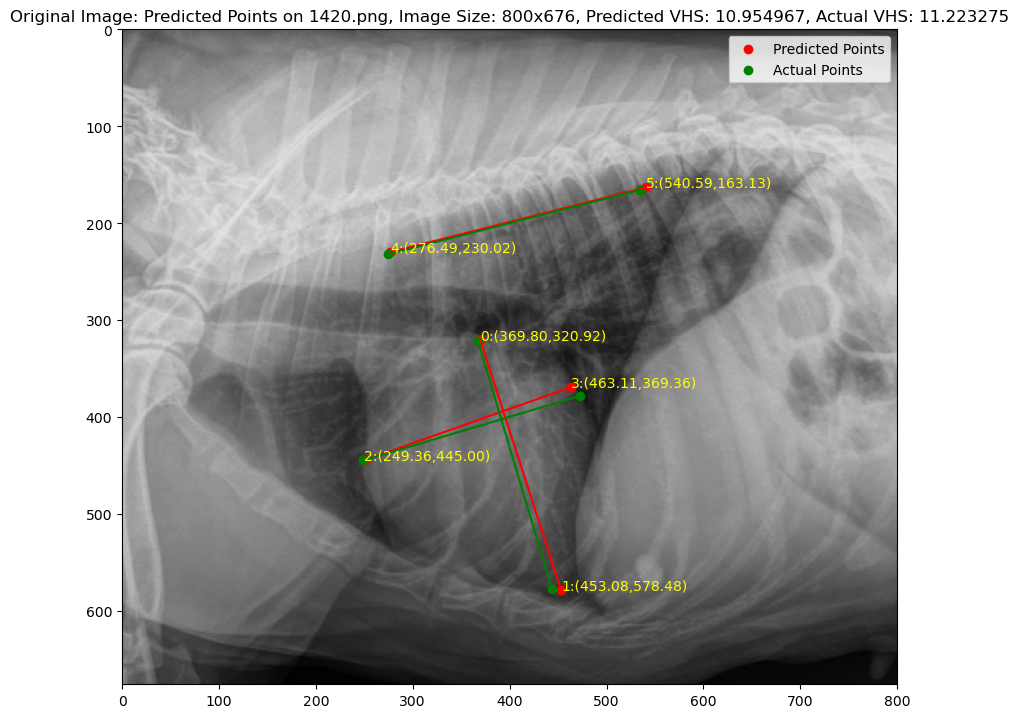

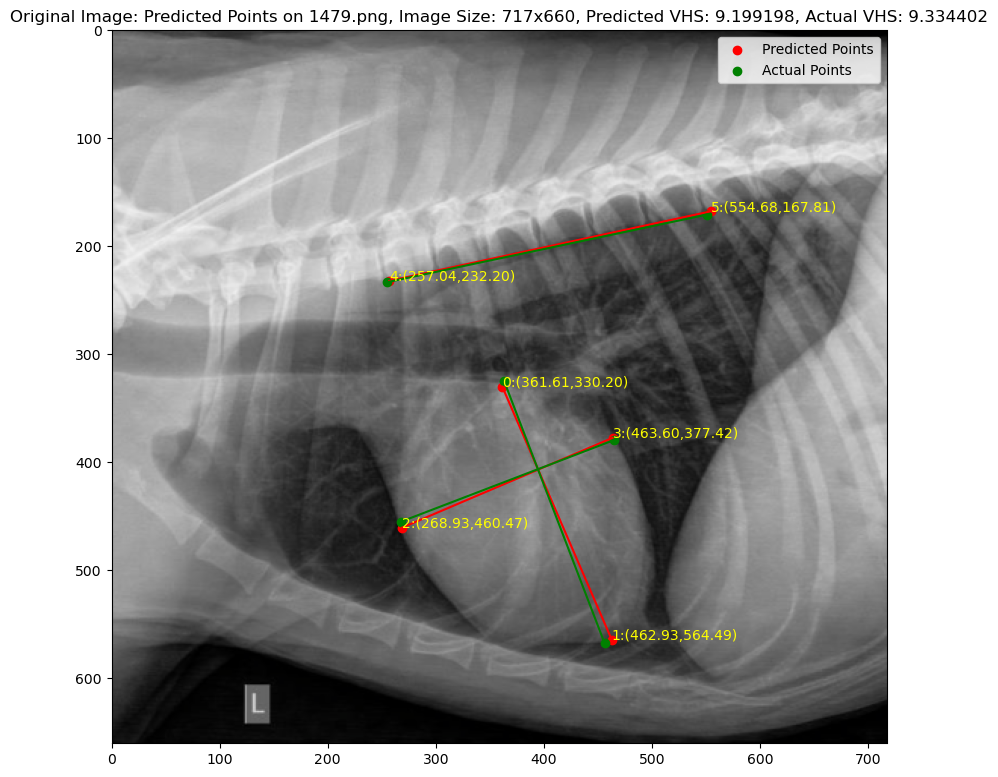

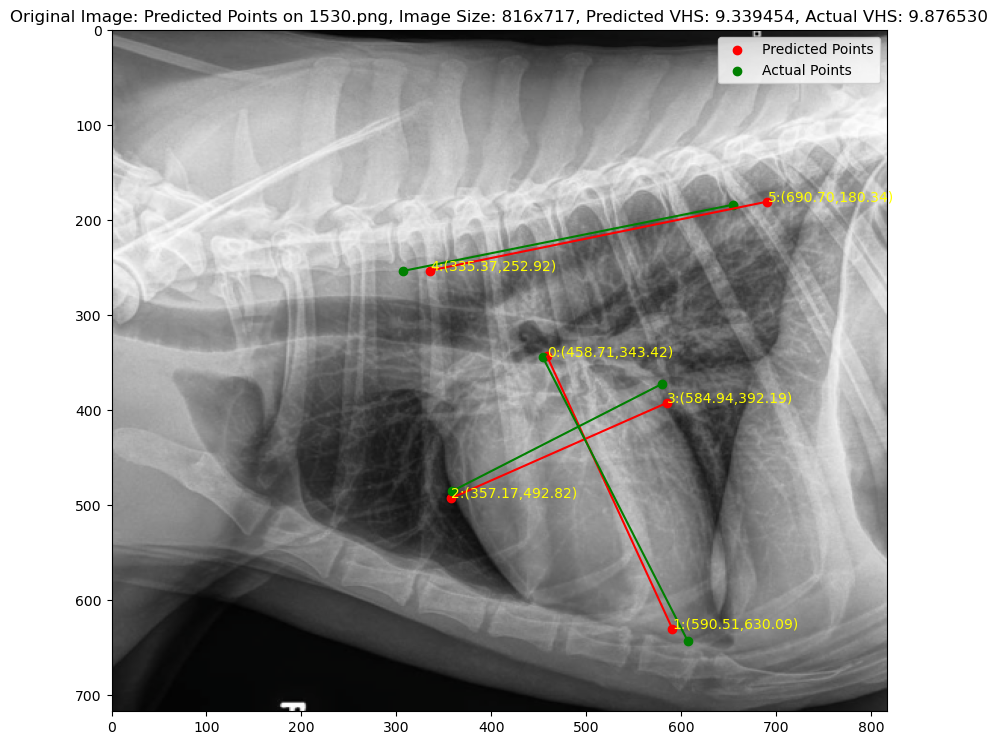

In [12]:
from IPython.display import Image, display

# Display the image
image_path = '/content/comp1.png'  # Path to the image in the root directory of Colab
display(Image(filename=image_path))

# Display the image
image_path = '/content/comp2.png'  # Path to the image in the root directory of Colab
display(Image(filename=image_path))

# Display the image
image_path = '/content/comp3.png'  # Path to the image in the root directory of Colab
display(Image(filename=image_path))

# 6. Write a three-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


# 7. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, prediction CSV file and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points

# 8. Bonus points (10 points if your accuracy is higer than 87.3%)